In [6]:
import os
import glob
import numpy as np
from sklearn import metrics
from work_v2 import get_model, get_test_datagen, count_files
import itertools
import matplotlib.pyplot as plt

In [7]:
def scores_from_model_top(group, position, model, top):
    weights_path = 'models/{group}/{position}/{model}/{top}/top_trained.h5'.format(position=position, group=group,
                                                                                   model=model, top=top)
    test_path = 'data/{position}_256/{group}/test/'.format(position=position, group=group)
    n_test_samples = count_files(test_path)
    n_steps_test = np.ceil(n_test_samples / batch_size)
    full_model = get_model(model, top)
    full_model.load_weights(weights_path)
    test_datagen = get_test_datagen(model)
    target_size = (224, 224)
    test_generator = test_datagen.flow_from_directory(
        test_path,
        # target_size=(224, 224),
        reader_config={'target_mode': 'RGB', 'target_size': target_size},
        batch_size=batch_size,
        shuffle=False)
    preds = full_model.predict_generator(
        generator=test_generator,
        steps=n_steps_test,
        workers=4,
        verbose=1)
    scores = preds[:, 1]
    return scores


def ensemble_roc_auc(y, scores, combination):
    ensemble_score = np.mean([scores[combination[0]], scores[combination[1]]], axis=0)
    fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc


def ensemble_precision_recall(y, scores, combination):
    ensemble_score = np.mean([scores[combination[0]], scores[combination[1]]], axis=0)
    precision, recall, thresholds = metrics.precision_recall_curve(y, ensemble_score)
    return precision, recall, thresholds


In [8]:
def count_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
        return cnt


In [9]:
groups = ['M_Adult']
positions = ['PA', 'LAT']
models = ['resnet50', 'vgg16', 'vgg19']
tops = ['waya', 'chollet', 'linear']

In [10]:
batch_size = 32
scores = [scores_from_model_top(group, position, model, top) for group, position, model, top in
          itertools.product(groups, positions, models, tops)]
np.save('scores.npy', scores)
# num_files = sum(os.path.isfile(os.path.join(test_path, f)) for f in os.listdir(test_path))
# y = num_files/2 * [0] + num_files/2 * [1]
# combinations = [comb for comb in itertools.combinations(range(9), 2)]
# aucs = [ensemble_roc_auc(y, scores, comb) for comb in combinations]



Found 796 images belonging to 2 classes.
25/25 [==============================] - 10s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 9s     
Found 796 images belonging to 2 classes.
25/25 [==============================] - 9s     
Found 796 images belonging to 2 classes.
25/25 [==============================] - 18s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 13s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 13s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 16s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 16s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 16s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 10s    
Found 796 images belonging to 2 classes.
25/25 [==============================] - 10s    
Found 796 

In [38]:
scores_np = np.array(scores)

In [39]:
scores_np.shape

(18, 796)

In [40]:
comb_aucs = []
comb_precision = []
comb_recall = []
for i_group, group in enumerate(groups):
    for i_model, model in enumerate(models):
        test_path = 'data/PA_256/{group}/test/'.format(group=group)
        num_files = count_files(test_path)
#         num_files = sum(os.path.isfile(os.path.join(test_path, f)) for f in os.listdir(test_path))
        y = int(num_files / 2) * [0] + int(num_files / 2) * [1]
        for i_top, top in enumerate(tops):
            PA_model_score = scores_np[i_model*3+i_top,:]
            LAT_model_score = scores_np[9+i_model*3+i_top,:]
            ensemble_score = np.mean([PA_model_score, LAT_model_score], axis=0)
            fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
            roc_auc = metrics.auc(fpr, tpr)
            comb_aucs.append(roc_auc)
            precision, recall, thresholds = metrics.precision_recall_curve(y, ensemble_score)
            comb_precision.append(precision)
            comb_recall.append(recall)
np.save('comb_aucs.npy', comb_aucs)
np.save('comb_precision.npy', comb_precision)
np.save('comb_recall.npy', comb_recall)

In [46]:
all_comb_auc = []
for PA_id, LAT_id in itertools.product(range(9), range(9,18)):
    PA_model_score = scores_np[PA_id, :]
    LAT_model_score = scores_np[LAT_id, :]
    ensemble_score = np.mean([PA_model_score, LAT_model_score], axis=0)
    fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    all_comb_auc.append(roc_auc)
top_comb = np.argmax(all_comb_auc)
np.max(all_comb_auc)

0.69314537511678997

In [47]:
combs = [(i,j) for i,j in itertools.product(range(9), range(9,18))]
comb_names = [(m1, m2) for m1, m2 in itertools.product(models, tops)]
comb_names_sq = [(c1, c2) for c1, c2 in itertools.product(comb_names, comb_names)]

In [48]:
comb_names_sq[top_comb]

(('vgg19', 'waya'), ('vgg16', 'waya'))

In [49]:
top_PA_id = combs[top_comb][0]
top_LAT_id = combs[top_comb][1]

PA_model_score = scores_np[top_PA_id, :]
LAT_model_score = scores_np[top_LAT_id, :]

In [69]:
inc_auc = []
for i in range(1,10):
    ensemble_score = np.mean([(i/10)*PA_model_score,(1-i/10)*LAT_model_score], axis=0)
    fpr, tpr, thresholds = metrics.roc_curve(y, ensemble_score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    inc_auc.append(roc_auc)


In [70]:
xmax = np.argmax(inc_auc)
ymax = np.round(np.max(inc_auc), 4)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(1, 10), inc_auc)

ax.annotate('max_auc = {}'.format(ymax), xy=(xmax, ymax), xytext=(2, ymax),
            arrowprops=dict(facecolor='black', shrink=0.05))



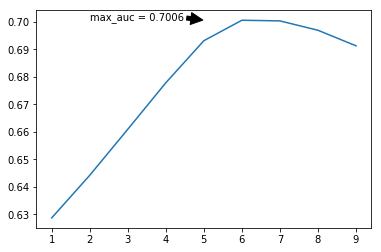

In [71]:
plt.show()